<a href="https://colab.research.google.com/github/sandesarikeerthi/2303a51635-batch-23/blob/main/procode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-4238711209.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu = float((theta.T @ x))
/tmp/ipython-input-4238711209.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu = float((theta.T @ x))



=== Test Accuracy / Avg Reward ===
Epsilon-Greedy  : acc=0.511  reward=0.511
LinUCB          : acc=0.638  reward=0.638
LinThompson     : acc=0.617   reward=0.617
DQN             : acc=0.638  reward=0.638


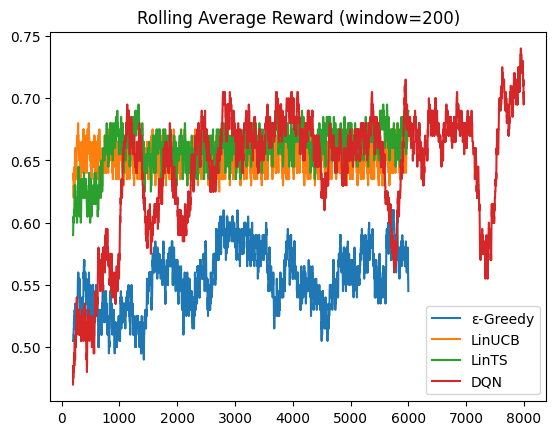

In [2]:
import os, math, random, time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

CSV_PATH = "/content/universities_cleaned.csv"
df = pd.read_csv(CSV_PATH)

for col in ["index","Index","Unnamed: 0"]:
    if col in df.columns:
        df = df.drop(columns=[col])

def clean_currency(s):
    return pd.to_numeric(s.astype(str).str.replace(r'[^0-9.]','',regex=True), errors='coerce')

def clean_int(s):
    return pd.to_numeric(s.astype(str).str.replace(r'[^0-9]','',regex=True), errors='coerce')

df["Tuition and fees"] = clean_currency(df["Tuition and fees"])
df["Undergrad Enrollment"] = clean_int(df["Undergrad Enrollment"])
df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")
df = df.dropna(subset=["Tuition and fees","Undergrad Enrollment","Rank"]).copy()

X = pd.DataFrame({
    "tuition": df["Tuition and fees"].astype(float),
    "enroll": df["Undergrad Enrollment"].astype(float),
})
X["tui_per_student"] = X["tuition"] / (X["enroll"] + 1.0)
X["log_tuition"] = np.log1p(X["tuition"])
X["log_enroll"] = np.log1p(X["enroll"])

y_bins = pd.qcut(df["Rank"], q=3, labels=[0,1,2]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y_bins.values, test_size=0.2, random_state=42, stratify=y_bins
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

n_features = X_train.shape[1]
n_actions  = 3
rng = np.random.RandomState(42)

class ContextualBanditEnv:
    def __init__(self, X, y, shuffle=True, seed=42):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.shuffle = shuffle
        self.rng = np.random.RandomState(seed)
        self.idx = 0
        self.order = np.arange(self.n)
        if self.shuffle: self.rng.shuffle(self.order)
    def reset(self):
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.idx = 0
        return self.X[self.order[self.idx]], self.y[self.order[self.idx]]
    def step(self, action):
        i = self.order[self.idx]
        true_a = self.y[i]
        reward = 1.0 if action == true_a else 0.0
        self.idx = (self.idx + 1) % self.n
        s_next = self.X[self.order[self.idx]]
        y_next = self.y[self.order[self.idx]]
        done = False
        return s_next, y_next, reward, done

class EpsilonGreedyLinear:
    def __init__(self, d, k, lr=0.05, eps=0.1, seed=42):
        self.W = np.zeros((k, d))
        self.lr = lr
        self.eps = eps
        self.rng = np.random.RandomState(seed)
    def policy(self, x):
        logits = self.W @ x
        return np.argmax(logits)
    def act(self, x):
        if self.rng.rand() < self.eps:
            return self.rng.randint(0, self.W.shape[0])
        return self.policy(x)
    def update(self, x, a, r):
        pred = self.W @ x
        target = np.zeros_like(pred); target[a] = r
        grad = (pred - target).reshape(-1,1) * x.reshape(1,-1)
        self.W -= self.lr * grad

class LinUCB:
    def __init__(self, d, k, alpha=1.0):
        self.d, self.k = d, k
        self.alpha = alpha
        self.A = [np.eye(d) for _ in range(k)]
        self.b = [np.zeros((d,1)) for _ in range(k)]
    def act(self, x):
        x = x.reshape(-1,1)
        ucb = []
        for a in range(self.k):
            Ainv = np.linalg.inv(self.A[a])
            theta = Ainv @ self.b[a]
            mu = float((theta.T @ x))
            sigma = math.sqrt((x.T @ Ainv @ x).item())
            ucb.append(mu + self.alpha * sigma)
        return int(np.argmax(ucb))
    def update(self, x, a, r):
        x = x.reshape(-1,1)
        self.A[a] += x @ x.T
        self.b[a] += r * x

class LinThompsonSampling:
    def __init__(self, d, k, v=0.25, seed=42):
        self.d, self.k = d, k
        self.v = v
        self.A = [np.eye(d) for _ in range(k)]
        self.b = [np.zeros((d,1)) for _ in range(k)]
        self.rng = np.random.RandomState(seed)
    def act(self, x):
        x = x.reshape(-1,1)
        samples = []
        for a in range(self.k):
            Ainv = np.linalg.inv(self.A[a])
            mu = Ainv @ self.b[a]
            cov = self.v**2 * Ainv
            theta = self.rng.multivariate_normal(mean=mu.flatten(), cov=cov)
            samples.append(theta @ x.flatten())
        return int(np.argmax(samples))
    def update(self, x, a, r):
        x = x.reshape(-1,1)
        self.A[a] += x @ x.T
        self.b[a] += r * x

class QNet(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, out)
        )
    def forward(self, x): return self.net(x)

class DQNAgent:
    def __init__(self, d, k, lr=1e-3, gamma=0.99, eps_start=0.2, eps_end=0.01, eps_decay=0.995, seed=42):
        self.q = QNet(d, k)
        self.tgt = QNet(d, k)
        self.tgt.load_state_dict(self.q.state_dict())
        self.opt = optim.Adam(self.q.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.gamma = gamma
        self.eps = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.k = k
        torch.manual_seed(seed)
    def act(self, x_np):
        if np.random.rand() < self.eps:
            return np.random.randint(0, self.k)
        with torch.no_grad():
            qvals = self.q(torch.tensor(x_np, dtype=torch.float32).unsqueeze(0))
            return int(torch.argmax(qvals, dim=1).item())
    def update(self, x_np, a, r, x2_np):
        x = torch.tensor(x_np, dtype=torch.float32).unsqueeze(0)
        x2 = torch.tensor(x2_np, dtype=torch.float32).unsqueeze(0)
        a = torch.tensor([a], dtype=torch.long)
        r = torch.tensor([r], dtype=torch.float32)
        qvals = self.q(x).gather(1, a.view(-1,1)).squeeze(1)
        with torch.no_grad():
            tgt_max = self.tgt(x2).max(1)[0]
            y = r + self.gamma * tgt_max
        loss = self.loss_fn(qvals, y)
        self.opt.zero_grad(); loss.backward(); self.opt.step()
    def decay(self):
        self.eps = max(self.eps_end, self.eps * self.eps_decay)
    def sync(self):
        self.tgt.load_state_dict(self.q.state_dict())

def train_bandit(env, agent, steps=5000, sync_every=None):
    s, y = env.reset()
    rewards = []
    for t in range(steps):
        a = agent.act(s)
        s2, y2, r, done = env.step(a)
        if hasattr(agent, "update") and not isinstance(agent, DQNAgent):
            agent.update(s, a, r)
        if isinstance(agent, DQNAgent):
            agent.update(s, a, r, s2)
        rewards.append(r)
        s = s2; y = y2
        if hasattr(agent, "decay"):
            agent.decay()
        if sync_every and hasattr(agent, "sync") and (t+1) % sync_every == 0:
            agent.sync()
    return np.array(rewards)

def evaluate_policy(X_eval, y_eval, act_fn):
    preds = [act_fn(X_eval[i]) for i in range(len(X_eval))]
    acc = accuracy_score(y_eval, preds)
    reward = np.mean((np.array(preds) == y_eval).astype(float))
    return acc, reward

env_train = ContextualBanditEnv(X_train, y_train, shuffle=True, seed=123)
eps_agent = EpsilonGreedyLinear(n_features, n_actions, lr=0.05, eps=0.1)
linucb_agent = LinUCB(n_features, n_actions, alpha=1.0)
ts_agent = LinThompsonSampling(n_features, n_actions, v=0.25)
dqn_agent = DQNAgent(n_features, n_actions, lr=1e-3, eps_start=0.2, eps_end=0.01, eps_decay=0.999)

r_eps  = train_bandit(env_train, eps_agent,  steps=6000)
r_ucb  = train_bandit(env_train, linucb_agent, steps=6000)
r_ts   = train_bandit(env_train, ts_agent,    steps=6000)
r_dqn  = train_bandit(env_train, dqn_agent,   steps=8000, sync_every=400)

acc_eps, rew_eps = evaluate_policy(X_test, y_test, lambda x: eps_agent.policy(x))
acc_ucb, rew_ucb = evaluate_policy(X_test, y_test, lambda x: linucb_agent.act(x))
acc_ts,  rew_ts  = evaluate_policy(X_test, y_test, lambda x: ts_agent.act(x))
dqn_agent.eps = 0.0
acc_dqn, rew_dqn = evaluate_policy(X_test, y_test, lambda x: dqn_agent.act(x))

print("\n=== Test Accuracy / Avg Reward ===")
print(f"Epsilon-Greedy  : acc={acc_eps:.3f}  reward={rew_eps:.3f}")
print(f"LinUCB          : acc={acc_ucb:.3f}  reward={rew_ucb:.3f}")
print(f"LinThompson     : acc={acc_ts:.3f}   reward={rew_ts:.3f}")
print(f"DQN             : acc={acc_dqn:.3f}  reward={rew_dqn:.3f}")

plt.figure()
plt.plot(pd.Series(r_eps).rolling(200).mean(), label='ε-Greedy')
plt.plot(pd.Series(r_ucb).rolling(200).mean(), label='LinUCB')
plt.plot(pd.Series(r_ts).rolling(200).mean(), label='LinTS')
plt.plot(pd.Series(r_dqn).rolling(200).mean(), label='DQN')
plt.title("Rolling Average Reward (window=200)")
plt.legend(); plt.show()
